In [1]:
from preprocess.pipelinesV2 import build_pipeline, build_coco_pipeline
import tensorflow as tf
import re
import numpy as np
import matplotlib.pyplot as plt
import time

/home/jupyter/MedClip/src/venv/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# data=build_pipeline(inter_dataset_path='../data/intermediate/inter_medpix.csv',
#                    image_size=(299, 299),
#                    train_val_test_split=[0.90,0.05,0.05])
data=build_coco_pipeline()

Loading coco...
remember coco dataset has 5 captions per image so  the value for the "text" key will be a (5,) string array.


2023-01-25 20:00:51.214772: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-25 20:00:51.227833: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-25 20:00:51.229687: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-25 20:00:51.232617: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

# The configuration dictionary

In [117]:
# Unpack parameters
config={
    'seq_len':50,
    'num_heads':1,
    'model_dim':100,
    'dropout':0.2,
    'img_backbone_trainable':False,
    'img_size':(299,299,3),
    'img_backbone':'efficientnetb0',
    'intermediate_size':100*4,
    'vocab_size':None,
    'capts_per_img':1,
    'num_encoder_blocks':3,
    'num_decoder_blocks':3,
}


# Tokenizer Class

In [100]:
class CustomTokenizer(object):
    def __init__(self):
        super().__init__()
        self.vocabulary=None
        self.vocab_size=None
    def build_vocabulary(self, tokenizer_data):
        pass
    def tokenize(self, sequence):
        pass
    def untokenize(self, token_sequence):
        pass
        
        

In [101]:
class KerasTokenizer(CustomTokenizer):
    def __init__(self,seq_len):
        super().__init__()
        self.seq_len=seq_len
        # Initialize keras tokenizer
        self.tokenizer=tf.keras.layers.TextVectorization(
            max_tokens=None,
            standardize=self.standarize,
            split='whitespace',
            ngrams=None,
            output_mode='int',
            output_sequence_length=self.seq_len,
            pad_to_max_tokens=False,
            vocabulary=None,
            idf_weights=None,
            sparse=False,
            ragged=False)
    
    def standarize(self, input_string):
        # strip_chars = "!\"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"
        # strip_chars = strip_chars.replace("<", "")
        # strip_chars = strip_chars.replace(">", "")
        # lowercase = tf.strings.lower(input_string)
        # final_string =tf.strings.regex_replace(lowercase, "[%s]" % re.escape(strip_chars), "")
        lowercase = tf.strings.lower(input_string)
        
        strip_chars = "!\"#$%&()*+;=?@[\]^_`{|}~"
        final_string =tf.strings.regex_replace(lowercase, "[%s]" % re.escape(strip_chars), "")
        
        final_string =tf.strings.regex_replace(final_string, "[%s]" % re.escape('.'), " . ")
        final_string =tf.strings.regex_replace(final_string, "[%s]" % re.escape(','), " , ")

        # Replace 1cm and 2mm for 1 cm and 2 mm
        final_string= tf.strings.regex_replace(final_string, 
                                               r'([0-9]+)(cm|mm)', 
                                               r'\1 \2', 
                                               replace_global=True, 
                                               name=None
                                               )
        return final_string 
    
    def build_vocabulary(self,tokenizer_data):
        """
        Args: 
            tokenizer_data(list): list of all strings
        """
        self.tokenizer.adapt(tokenizer_data)
        self.vocab_size = self.tokenizer.vocabulary_size()
        self.vocabulary = self.tokenizer.get_vocabulary()
        return
    
    def tokenize(self, input_string):
        return self.tokenizer(input_string)
    
    def untokenize(self, tokens):
        if tf.is_tensor(tokens):
            tokens_list=list(tokens.numpy())
            
        if isinstance(tokens, np.ndarray):
            tokens_list=list(tokens)
        
        
        output_string_list=[]        
        for token in tokens_list: 
            output_string_list.append(self.vocabulary[token])
        output_string=' '.join(output_string_list).strip()
        return output_string

        
        

# The tokenizer

In [118]:
# Get the training texts
tokenizer_data=data['captioning']['train_captions'].take(1000)

# Initialize tokenizer
tokenizer=KerasTokenizer(seq_len=config['seq_len'])
tokenizer.build_vocabulary(tokenizer_data)
config['vocab_size']=tokenizer.vocab_size





In [107]:
# Add tokenizing step to pipeline
def tokenize(ds_row):
    tokens=tokenizer.tokenize(ds_row['text'])
    return {'image':ds_row['image'],
           'text':ds_row['text'],
           'tokens':tokens}
batch_size=32
# Obtain data for training, validation and test 
train_data = data['captioning']['train'].map(tokenize,num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size)
val_data = data['captioning']['val'].map(tokenize,num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size)
test_data = data['captioning']['test'].map(tokenize,num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size)

# train_data = data['captioning']['train'].batch(batch_size)
# val_data = data['captioning']['val'].batch(batch_size)
# test_data = data['captioning']['test'].batch(batch_size)

# Obtain training tokens and images for implementation tests. 
train_tokens=train_data.map(lambda x:x['tokens'])
train_images=train_data.map(lambda x:x['image'])

# The model

## Encoder part
### Image encoder layer
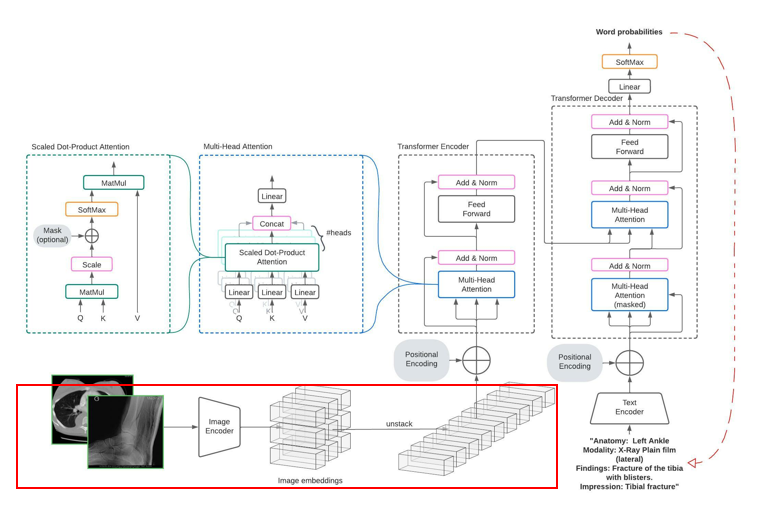

In [10]:
# The encoder layer

# The image encoder class
class ImageEncoder(tf.keras.layers.Layer):
    def __init__(self,config):
        """
        Image encoder class. 
        
        The layer takes images and returns a sequence of vectors 
        corresponding to the last convolutional volume of the given 
        backbone network after being projected to the model's dimension
        "model_dim". 
        
        Args: 
            config(dict): A configuration dictionary. Must contain keys:
                'img_backbone_trainable': whether the backbone is trainable
                'img_size': the resolution of the image ex: (299,299,3)
                'img_backbone': Currently only efficientnetB0 is implemented
        """
        super().__init__()
        # Base attrobites 
        self.backbone = config['img_backbone']
        self.img_size = config['img_size']
        self.img_backbone_trainable = config['img_backbone_trainable']
        
        # Initialize backbone model
        self.backbone_model = None # initialized bellow in init_backbone()
        self.init_backbone()
        
        # Other model layers
        self.reshape = tf.keras.layers.Reshape(
            (-1,self.backbone_model.output.shape[-1])
        )
        self.projection = tf.keras.layers.Dense(config['model_dim'])
        
    def call(self,inputs):
        x=self.backbone_model(inputs)
        x=self.reshape(x)
        x=self.projection(x)
        return x
    
    def init_backbone(self):
        """Initializes the backbone model."""
        
        if self.backbone=='efficientnetb0':
            # Notice that the images must be in float format (299,299,3) and go from 0 to 255
            self.backbone_model = tf.keras.applications.efficientnet.EfficientNetB0(
                input_shape=self.img_size, include_top=False, weights="imagenet",
            )
        # Implement other backbones here
        else: 
            # If backbone is not recognized.
            print(f'backbone {self.backbone} not implemented')
        
        # Set backbone model trainability. 
        self.backbone_model.trainable = self.img_backbone_trainable
        
        
        

#### Image encoder tests

In [26]:
train_images

<MapDataset element_spec=TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name=None)>

In [14]:
tick=time.time()
for i in train_images.take(1):
    tock=time.time()
print(tock-tick)

0.3847174644470215


In [12]:
# Tests
# Image encoder test
image_encoder = ImageEncoder(config)
for inputs in train_images.take(1):
    print(f'Before ImageEncoder: {inputs.shape}')
    tick=time.time()
    x=image_encoder(inputs)
    tock=time.time()
    print(tock-tick)
    print(f'After ImageEncoder: {x.shape}')

2023-01-25 07:14:22.621205: W tensorflow/core/common_runtime/bfc_allocator.cc:462] Allocator (GPU_0_bfc) ran out of memory trying to allocate 150.0KiB (rounded to 153600)requested by op AddV2
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-01-25 07:14:22.621273: I tensorflow/core/common_runtime/bfc_allocator.cc:1010] BFCAllocator dump for GPU_0_bfc
2023-01-25 07:14:22.621285: I tensorflow/core/common_runtime/bfc_allocator.cc:1017] Bin (256): 	Total Chunks: 176, Chunks in use: 176. 44.0KiB allocated for chunks. 44.0KiB in use in bin. 13.5KiB client-requested in use in bin.
2023-01-25 07:14:22.621292: I tensorflow/core/common_runtime/bfc_allocator.cc:1017] Bin (512): 	Total Chunks: 151, Chunks in use: 151. 94.2KiB allocated for chunks. 94.2KiB in use in bin. 73.2KiB client-requested in use in bin.
2023-01-25 07:14:22.621299: I 

ResourceExhaustedError: failed to allocate memory [Op:AddV2]

ime/bfc_allocator.cc:1066] InUse at 7fbf8b2a6d00 of size 768 next 697
2023-01-25 07:14:22.627219: I tensorflow/core/common_runtime/bfc_allocator.cc:1066] InUse at 7fbf8b2a7000 of size 768 next 699
2023-01-25 07:14:22.627226: I tensorflow/core/common_runtime/bfc_allocator.cc:1066] InUse at 7fbf8b2a7300 of size 768 next 700
2023-01-25 07:14:22.627233: I tensorflow/core/common_runtime/bfc_allocator.cc:1066] InUse at 7fbf8b2a7600 of size 768 next 701
2023-01-25 07:14:22.627241: I tensorflow/core/common_runtime/bfc_allocator.cc:1066] InUse at 7fbf8b2a7900 of size 256 next 704
2023-01-25 07:14:22.627248: I tensorflow/core/common_runtime/bfc_allocator.cc:1066] InUse at 7fbf8b2a7a00 of size 768 next 706
2023-01-25 07:14:22.627255: I tensorflow/core/common_runtime/bfc_allocator.cc:1066] InUse at 7fbf8b2a7d00 of size 256 next 709
2023-01-25 07:14:22.627262: I tensorflow/core/common_runtime/bfc_allocator.cc:1066] InUse at 7fbf8b2a7e00 of size 256 next 710
2023-01-25 07:14:22.627270: I tensorflow/

### Positional embedding layer
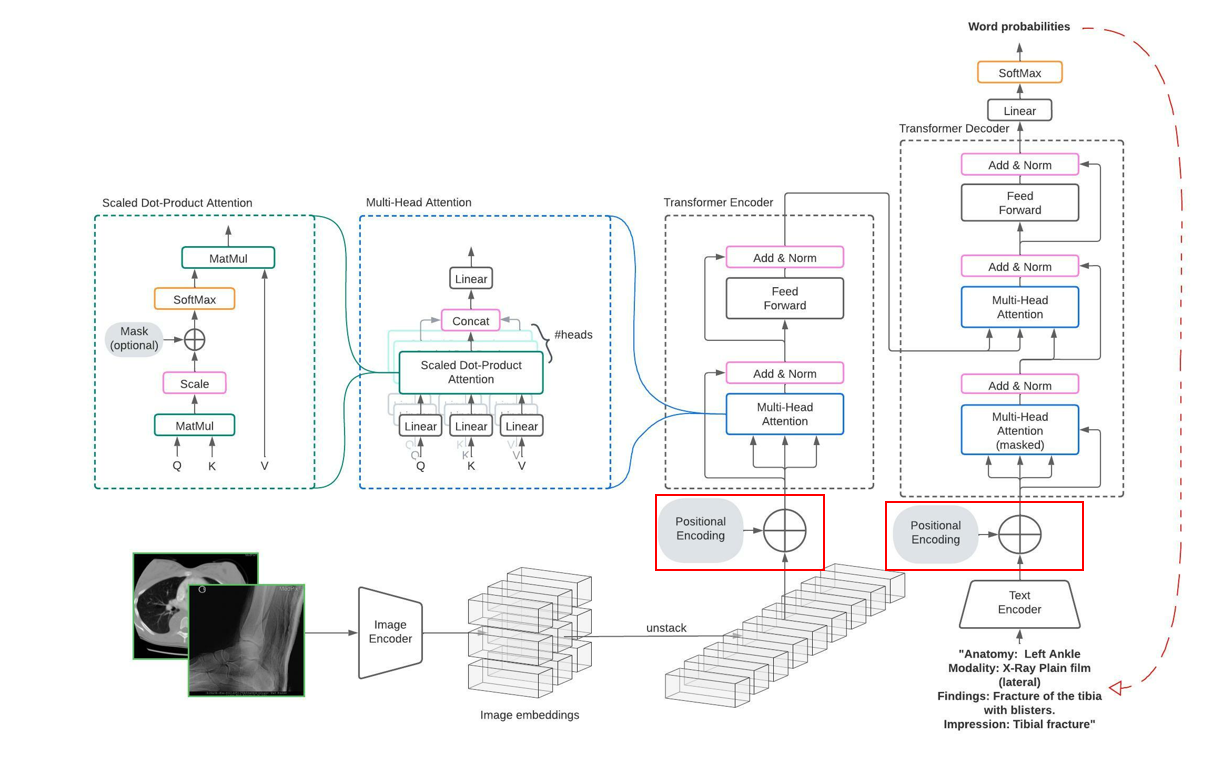

In [11]:
class PositionalEncoder(tf.keras.layers.Layer):
    """A layer that adds positional encoding to a squence of embeddings."""
    def __init__(self,config,seq_len,**kwargs):
        """Initialize a positional encoder. 
        
        Creates an learnable embedding matrix to represent positions for
        positional encoding. It also scales the resulting embeddings by the 
        square_root of the model dimension. 
        
        Args: 
        config(dict): A configuration dictionary that must contain:
            model_dim: The size of the embeddings. Typically 728.
        sequence_length: The size of the sequence for positional encoding. 
        """
        super().__init__(**kwargs)
        
        
        self.sequence_length=seq_len
        # Embedding layer that generates an embedding for 
        # every possible position in the sequence
        self.position_embeddings = tf.keras.layers.Embedding(
            input_dim=self.sequence_length, output_dim=config['model_dim']
        )
        # Scaling value = sqrt(model_dim)
        self.scale=tf.math.sqrt(tf.cast(config['model_dim'],tf.float32))

    def call(self,inputs):
        
        scaled_inputs=self.scale*inputs # scale inputs
        # Generate a positions array filled with
        # numbers from 0 to seq_length
        positions = tf.range(start=0, limit=self.sequence_length, delta=1) 
        # Create embeddings for every index in the positions array.
        embedded_positions = self.position_embeddings(positions)
        
        return embedded_positions+scaled_inputs
    

#### Positional embedding layer tests

In [56]:
image_encoder = ImageEncoder(config)
positional_encoder = PositionalEncoder(config,100)
for inputs in train_images.take(1):
    print(f'Before ImageEncoder: {inputs.shape}')
    x=image_encoder(inputs)
    print(f'After ImageEncoder: {x.shape}')
    tick=time.time()
    x=positional_encoder(x)
    tock=time.time()
    print(tock-tick)
    print(f'After PositionalEncoder: {x.shape}')

Before ImageEncoder: (32, 299, 299, 3)
After ImageEncoder: (32, 100, 100)
0.0022902488708496094
After PositionalEncoder: (32, 100, 100)


### The feedforward network
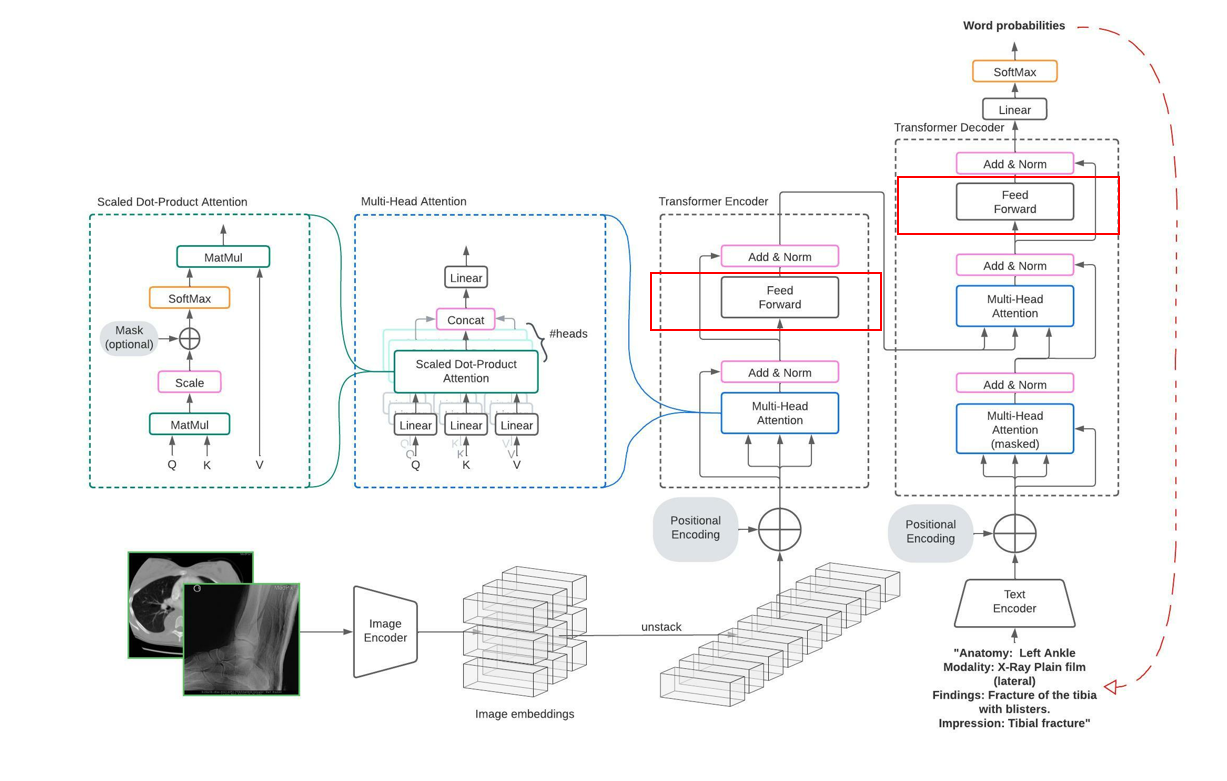

In [12]:
class FeedForward(tf.keras.layers.Layer):
    """The feed forward network of the transformer. 
    
    A dense feed forward network that operates on each embedding individually. 
    It is composed by two linear layers with a gelu activation in between. 
    """
    def __init__(self,config,**kwargs):
        """Initializes layers for feedforward network. 
        
        Args: 
            config(dict): A configuration dictionary that must contain: 
                'intermediate_size': An int with the size of the intermediate
                    layer. 
                'model_dim': The dimension of the transformer embeddings.
                'dropout': The dropout rate.                 
        """
        super().__init__(**kwargs)
        self.linear_1 = tf.keras.layers.Dense(config['intermediate_size'],
                                             activation='gelu')
        self.linear_2 = tf.keras.layers.Dense(config['model_dim'])
        
        self.dropout = tf.keras.layers.Dropout(config['dropout'])
    
    def call(self,inputs):
        x=self.linear_1(inputs)
        x=self.linear_2(x)
        x=self.dropout(x)
        return x
        
            
    

#### Feedforward test

In [58]:
feed_forward=FeedForward(config)
inputs= tf.random.uniform(shape=(64,100,728))
print(f'Before FeedForward network: {inputs.shape}')
tick=time.time()
x = feed_forward(inputs)
tock=time.time()
print(tock-tick)

print(f'After FeedForward network:{x.shape}')


Before FeedForward network: (64, 100, 728)
0.007734775543212891
After FeedForward network:(64, 100, 100)


### TranformerEncoder
We decided to post layer normalization because this is how the original captioning model worked in keras example 
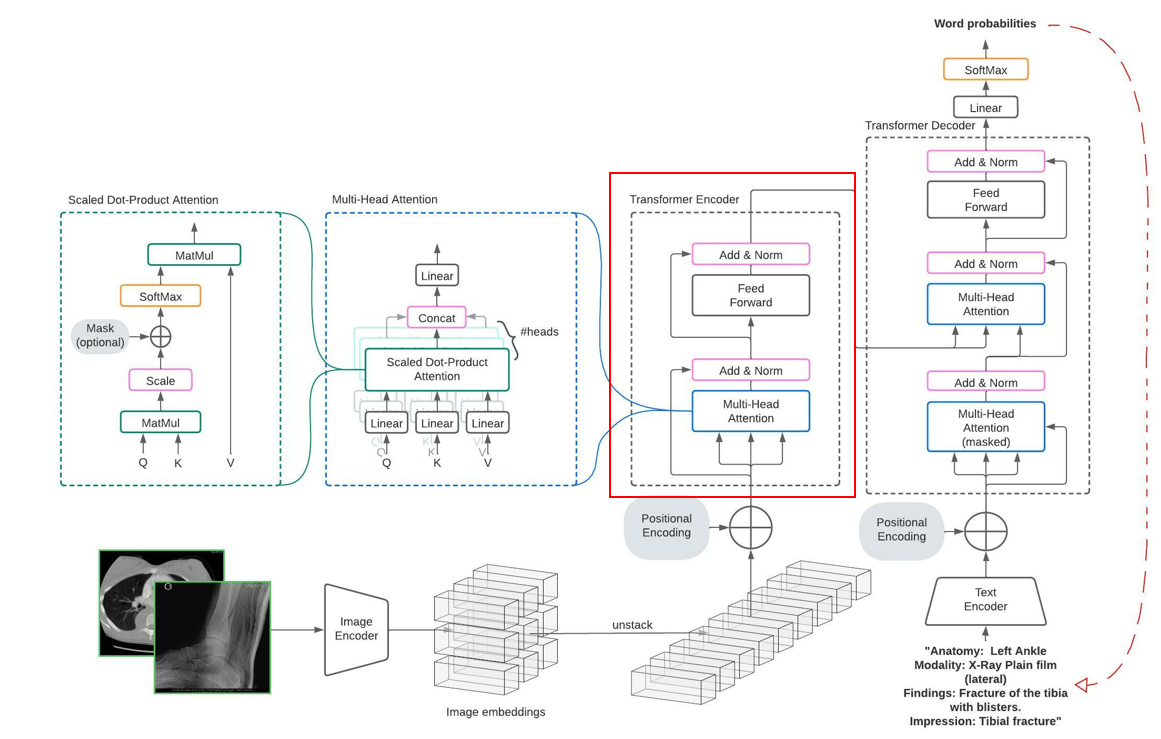


In [13]:
class TransformerEncoder(tf.keras.layers.Layer):
    """The transformer encoder part without positional encoding. """
    def __init__(self,config,**kwargs):
        super().__init__( **kwargs)
        self.layer_norm_1=tf.keras.layers.LayerNormalization()
        self.layer_norm_2=tf.keras.layers.LayerNormalization()
        self.mha=tf.keras.layers.MultiHeadAttention(
            num_heads=config['num_heads'],
            key_dim=100, # The dimensions of the dot product for attention in every head
            value_dim=None,
            dropout=config['dropout']
        )
        self.ffw=FeedForward(config)
    def call(self,inputs):
        x=self.mha(query = inputs,
                   value = inputs,
                   key = inputs)
        x1=self.layer_norm_1(x+inputs)
        x=self.ffw(x1)
        x=self.layer_norm_2(x+x1)
        return(x)

#### Transformer Encoder Test

In [60]:
image_encoder = ImageEncoder(config)
positional_encoder = PositionalEncoder(config,seq_len=100)
transformer_encoder = TransformerEncoder(config)
for inputs in train_images.take(1):
    print(f'Before ImageEncoder: {inputs.shape}')
    x=image_encoder(inputs)
    print(f'After ImageEncoder: {x.shape}')
    x=positional_encoder(x)
    print(f'After PositionalEncoder: {x.shape}')
    tick=time.time()
    x=transformer_encoder(x)
    tock=time.time()
    print(tock-tick)
    print(f'After transformer encoder:{x.shape}')

Before ImageEncoder: (32, 299, 299, 3)
After ImageEncoder: (32, 100, 100)
After PositionalEncoder: (32, 100, 100)
0.035274505615234375
After transformer encoder:(32, 100, 100)


### Full encoder
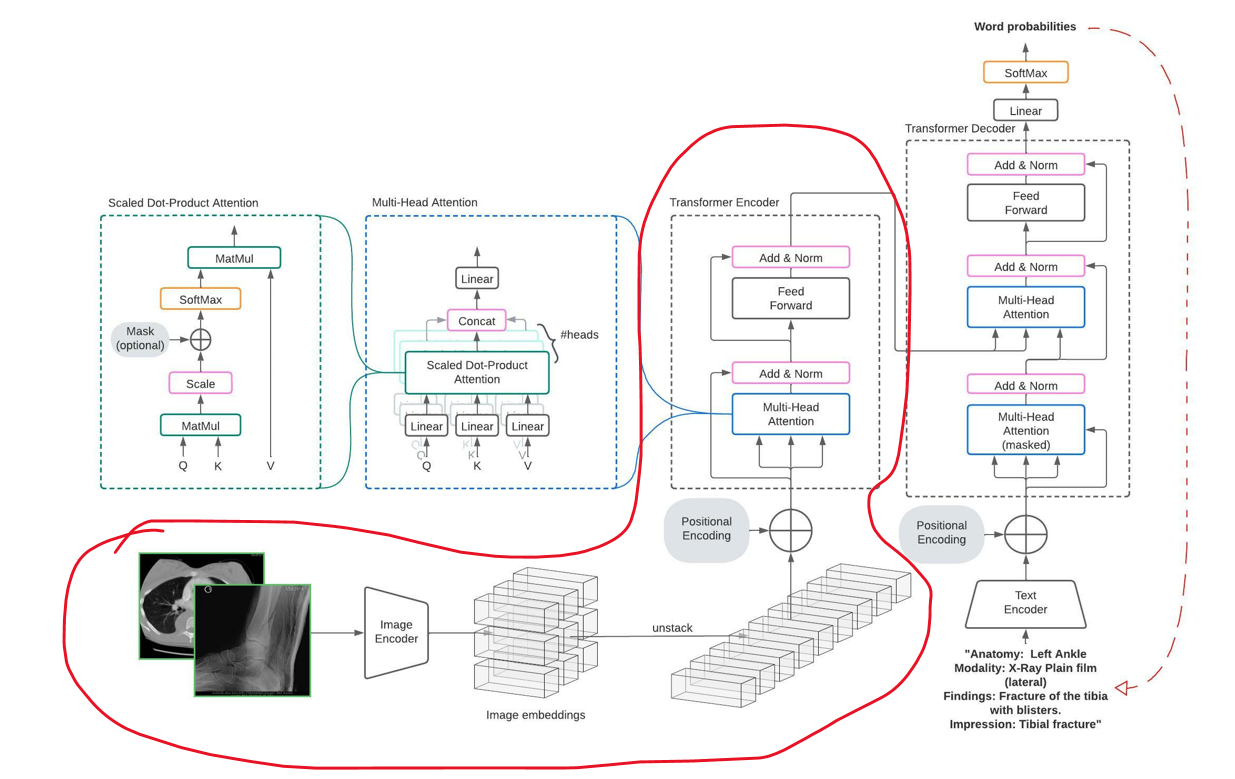

In [49]:
class FullEncoder(tf.keras.layers.Layer):
    """" The full encoder containing the image encoder, positional encoder and 
    transformer encoder"""
    def __init__(self,config,**kwargs):
        super().__init__(**kwargs)
        self.num_encoder_blocks=config['num_encoder_blocks']

        self.image_encoder = ImageEncoder(config)
        self.positional_encoder = PositionalEncoder(config,seq_len=100)
        self.transformer_encoders = [TransformerEncoder(config) 
                                     for _ in range(config['num_encoder_blocks'])]
    def call(self,inputs):
        x=self.image_encoder(inputs)
        x=self.positional_encoder(x)
        for i in range(self.num_encoder_blocks):
            x=self.transformer_encoders[i](x)
        return x
        
            

#### Full encoder test

In [64]:
encoder=FullEncoder(config)
for inputs in train_images.take(1):
    print(f'Before Encoder: {inputs.shape}')
    tick=time.time()
    x = encoder(inputs)
    tock=time.time()
    print(tock-tick)
    print(f'After Encoder: {x.shape}')

Before Encoder: (32, 299, 299, 3)
0.23304414749145508
After Encoder: (32, 100, 100)


## Decoder Part
### Text embeddings
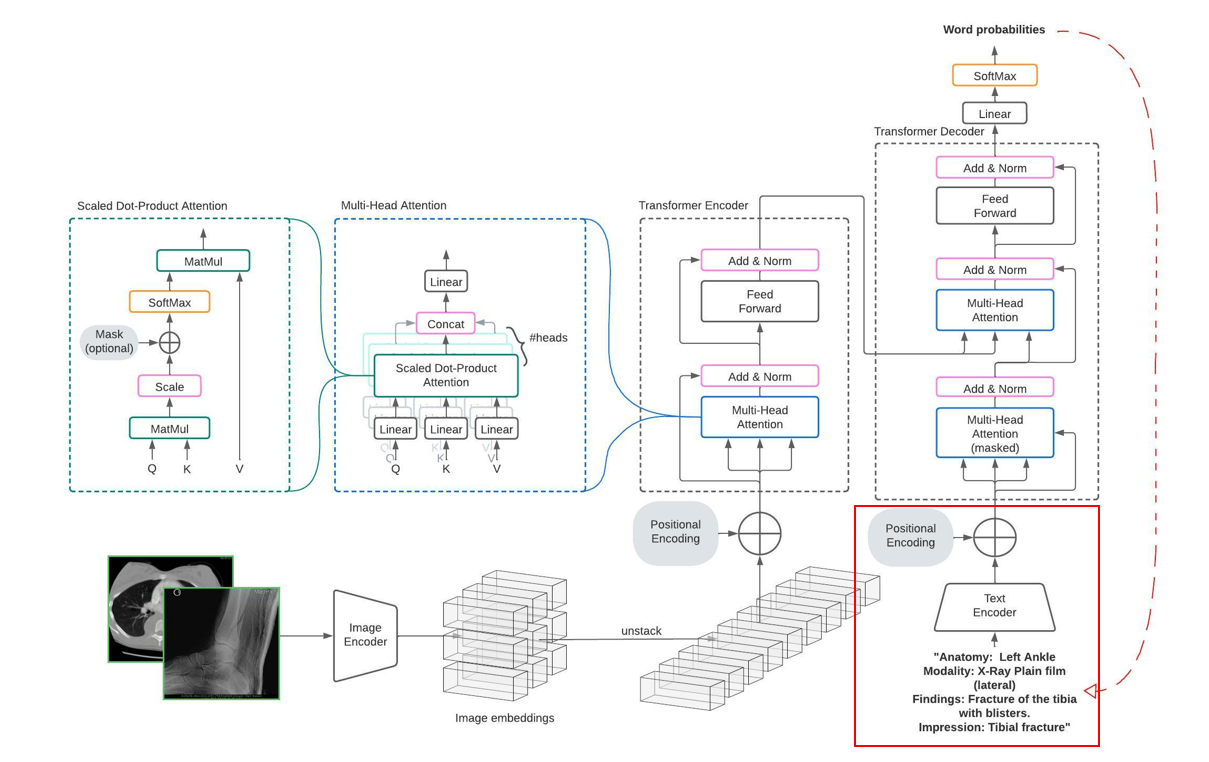

#### Text Embeddings test

In [15]:
class TextEmbeddings(tf.keras.layers.Layer):
    
    def __init__(self,config,**kwargs):
        """
        Receive tokens, embedd them and positionally encode them. 
        
        Args: 
            config(dict): a configuration dictionary
            
        """
        super().__init__(**kwargs)
        
        self.embeddings=tf.keras.layers.Embedding(config['vocab_size'],
                                                   config['model_dim'])
        self.positional=PositionalEncoder(config,seq_len=config['seq_len']-1)
        
    def call(self,inputs):
        # Inputs arrive as token sequences which are 
        # embedded by the "embeddings" matrix. 
        x=self.embeddings(inputs)
        x=self.positional(x) # Add positional encoding.
        return x
        

In [75]:
text_embeddings=TextEmbeddings(config)
for inputs in train_tokens.take(1):
    inputs=inputs[:,0,0:-1]
    print(inputs.shape)
    tick=time.time()
    x=text_embeddings(inputs)
    tock=time.time()
    print(tock-tick)
    print(x.shape)

(32, 69)
0.005152225494384766
(32, 69, 100)


### Transformer decoder
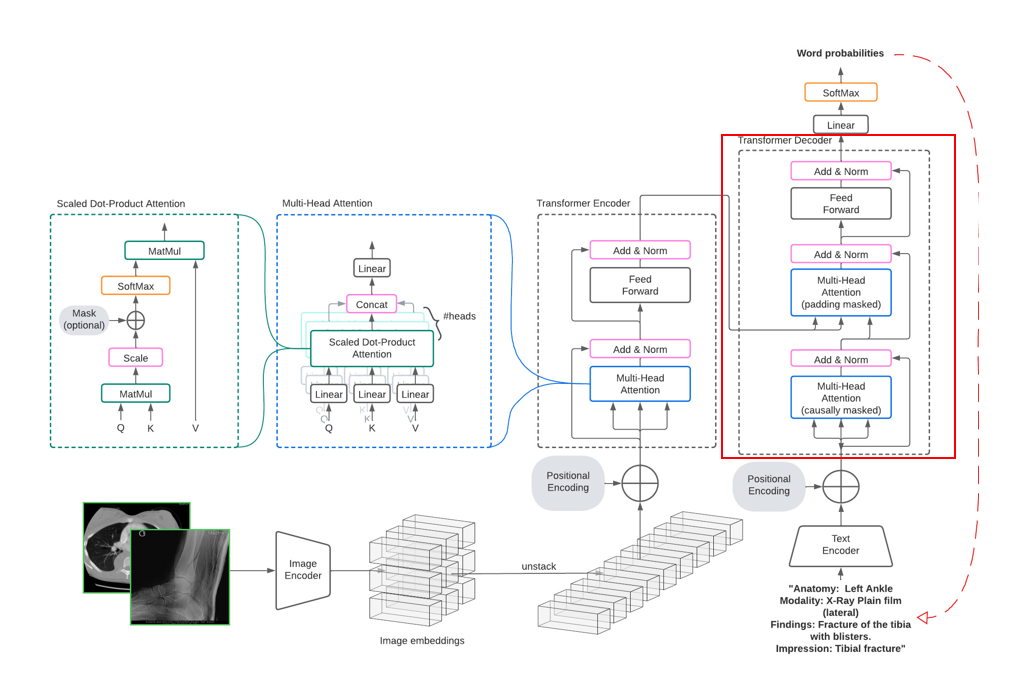
The decoder takes in embeddings that are already positionally encoded


In [16]:
class TransformerDecoder(tf.keras.layers.Layer):
    def __init__(self,config, **kwargs):
        super().__init__(**kwargs)
        self.mha_1=tf.keras.layers.MultiHeadAttention(num_heads=config['num_heads'],
                                                    key_dim=config['model_dim'],
                                                    dropout=config['dropout'])
        
        self.mha_2=tf.keras.layers.MultiHeadAttention(num_heads=config['num_heads'],
                                                    key_dim=config['model_dim'],
                                                    dropout=config['dropout'])
        self.layer_norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layer_norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layer_norm_3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        
        self.feed_forward=FeedForward(config)
   
    def call(self,text_inputs,image_inputs,mask):
        # Obtain the masks
        combined_mask=self.get_combined_mask(mask)
        padding_mask=tf.cast(mask[:, :, tf.newaxis], dtype=tf.int32)
       
        mha_1_out = self.mha_1(query=text_inputs,
                       value=text_inputs,
                       key=text_inputs,
                       attention_mask=combined_mask)
        norm_1_out = self.layer_norm_1(mha_1_out+text_inputs)
        
        mha_2_out = self.mha_2( query=norm_1_out,
                       value=image_inputs,
                       key=image_inputs,
                       attention_mask=padding_mask) 
        norm_2_out= self.layer_norm_2(mha_2_out+norm_1_out)
        
        ffw_out = self.feed_forward(norm_2_out)
        norm_3_out= self.layer_norm_3(ffw_out+norm_2_out)
        
        return norm_3_out
        
    def get_combined_mask(self,mask):
        input_shape = tf.shape(mask) # (batch_size, seq_len)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        h_mask = tf.cast(mask[:, tf.newaxis, :], dtype=tf.int32) # (batch_size,1,seq_len)

        # Generate the causal mask
        i = tf.range(sequence_length)[:,tf.newaxis]
        j = tf.range(sequence_length)
        d_mask = tf.cast(i >= j, dtype="int32") # Fill lower left diagonal
        d_mask = tf.reshape(d_mask, (1, input_shape[1], input_shape[1])) # Add batch dimension (1,seq_len,seq_len)

        # mult=tf.constant([batch_size.numpy(),1,1],dtype=tf.int32) 
        mult = tf.concat([tf.expand_dims(batch_size, -1), 
                          tf.constant([1, 1], 
                          dtype=tf.int32)],
                          axis=0,)
        causal_mask=tf.tile(d_mask,mult) # Tile along batch dimension (batch_size,seq_len,seq_len)

        # Combine causal mask and h_mask
        combined_mask = tf.minimum(h_mask, causal_mask) # (batch_size,seq_len,seq_len)
        return combined_mask

    
        

In [82]:
for i in train_data.take(1):
    images=i['image']
    tokens=i['tokens'][:,:,:]
    y_true, pred_tokens=tokens[:,0,1:],tokens[:,0,0:-1] # split predictors and targets
    mask=tf.math.not_equal(y_true,0) # Build mask for padding tokens.

    
full_encoder=FullEncoder(config)
text_encoder=TextEmbeddings(config)
transformer_decoder = TransformerDecoder(config)

image_inputs=full_encoder(images)
text_inputs=text_encoder(pred_tokens)

tick=time.time()
context=transformer_decoder(text_inputs,image_inputs,mask)
tock=time.time()
print(tock-tick)
print(context.shape)

0.03930401802062988
(32, 69, 100)


## Full decoder
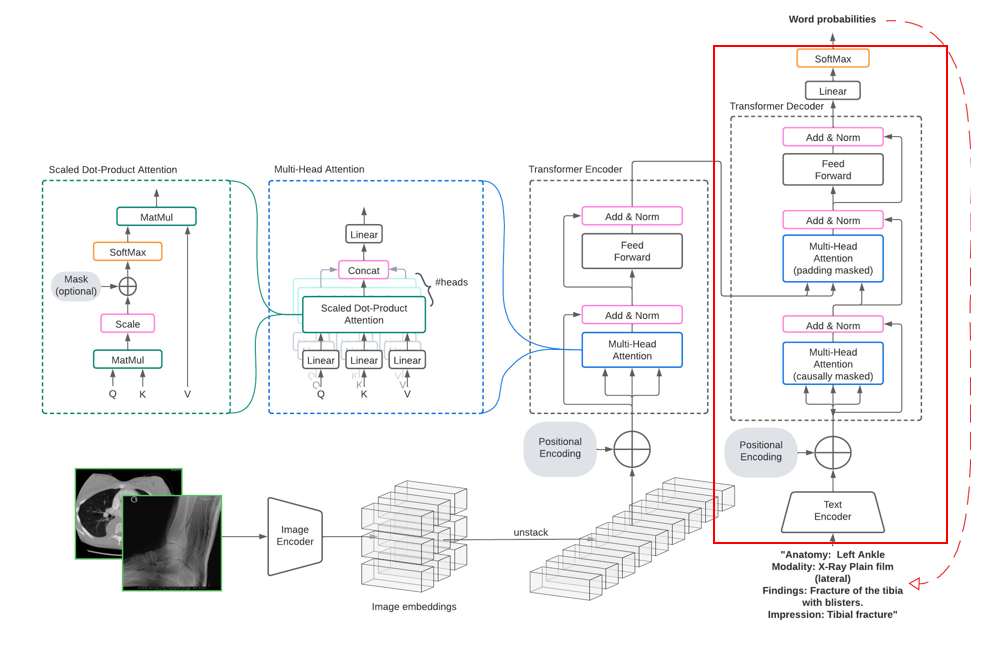

In [68]:
class FullDecoder(tf.keras.layers.Layer):
    def __init__(self,config,**kwargs):
        """ 
        Combines the TextEmbeddings, TransformerDecoder and output layers to 
        form a full decoder that takes in images and texts and outputs probabilities
        of words in the vocabulary. 

        Args: 
            config(dict): Configuration dictionary. 
            training_texts(tf.dataset): Texts to adapt the tokenizer.
            vocabulary_size(int): Vocab size.
        """
        super().__init__(**kwargs)
        self.num_decoder_blocks=config['num_decoder_blocks']
        
        self.text_embeddings=TextEmbeddings(config)
        self.transformer_decoder=[TransformerDecoder(config) 
                                  for _ in range(config['num_decoder_blocks'])]
        self.softmax=tf.keras.layers.Dense(config['vocab_size'],activation='softmax')
        
    def call(self,text_tokens,image_inputs,mask):
        x = self.text_embeddings(text_tokens)
        for i in range(self.num_decoder_blocks):
            x = self.transformer_decoder[i](x,image_inputs,mask)
        probs = self.softmax(x)
        return probs
        

In [83]:
for i in train_data.take(1):
    images=i['image']
    tokens=i['tokens'][:,:,:]
    y_true, pred_tokens=tokens[:,0,1:],tokens[:,0,0:-1] # split predictors and targets
    mask=tf.math.not_equal(y_true,0) # Build mask for padding tokens.


full_encoder=FullEncoder(config)
full_decoder=FullDecoder(config)
image_inputs=full_encoder(images)

tick=time.time()
probs=full_decoder(pred_tokens,image_inputs,mask)
tock=time.time()
print(tock-tick)
print(probs.shape)
# context=transformer_decoder(text_inputs,image_inputs,mask)


0.04532337188720703
(32, 69, 3430)


# Captioning Model  WE ARE HERE!


In [96]:
class CaptioningTransformer(tf.keras.Model):
    def __init__(self,config,**kwargs):
        super().__init__(**kwargs)

        self.encoder=FullEncoder(config)
        self.vocabulary_size=config['vocab_size']
        self.decoder=FullDecoder(config)
        self.capts_per_img=config['capts_per_img']
        
        self.loss_tracker = tf.keras.metrics.Mean(name="loss")
        self.acc_tracker = tf.keras.metrics.Mean(name="accuracy")
        
    @property
    def metrics(self):
        # We need to list our metrics here so the `reset_states()` can be
        # called automatically.
        return [self.loss_tracker, self.acc_tracker]
    
    def train_step(self,inputs):
        # Unpack the data..
        tokens=inputs['tokens']
        images=inputs['image']
        
        # Initialize batch_loss and batch_accuracy
        batch_loss=0
        batch_acc=0
        
        # Iterate over all captions for an image and do a forward
        # pass for each. 
        for i in range(self.capts_per_img):
        # For every caption corresponding to the same image:
            with tf.GradientTape() as tape:
                # Forward pass-------------------------------------
                y_true, pred_tokens=tokens[:,i,1:],tokens[:,i,0:-1] # split predictors and targets
                mask=tf.math.not_equal(y_true,0) # Build mask for padding tokens.
                image_inputs=self.encoder(images) # Run image through encoder
                y_pred=self.decoder(pred_tokens,image_inputs,mask) # Decode next word probabilities

                # Compute the loss value
                loss = self.calculate_loss(y_true,y_pred,mask)
                batch_loss+=loss
                
            # Backward pass-------------------------------
            # Compute gradients
            trainable_vars = self.trainable_variables
            gradients = tape.gradient(loss, trainable_vars)
            # Update weights
            self.optimizer.apply_gradients(zip(gradients, trainable_vars))
                
            # Compute other metrics--------------------
            acc = self.calculate_accuracy(y_true,y_pred,mask)
            batch_acc+=acc

        # Update metrics (includes the metric that tracks the loss)
        self.loss_tracker.update_state(batch_loss)
        self.acc_tracker.update_state(batch_acc/self.capts_per_img)
        
        # Return a dict mapping metric names to current value
        return {"loss": self.loss_tracker.result(), 'acc':self.acc_tracker.result()}
    
    def test_step(self,inputs):
        # Unpack the data..
        tokens=inputs['tokens']
        images=inputs['image']
        
        # Initialize batch_loss and batch_accuracy
        batch_loss=0
        batch_acc=0
        
        # Iterate over all captions for an image and do a forward
        # pass for each. 
        for i in range(self.capts_per_img):
        # For every caption corresponding to the same image:
            
            # Forward pass-------------------------------------
            image_inputs=self.encoder(images) # Run image through encoder
            
            y_true, pred_tokens=tokens[:,i,1:],tokens[:,i,0:-1] # split predictors and targets
            mask=tf.math.not_equal(y_true,0) # Build mask for padding tokens.
           
            y_pred=self.decoder(pred_tokens,image_inputs,mask) # Decode next word probabilities
            
            # Compute the loss value
            loss = self.calculate_loss(y_true,y_pred,mask)
            batch_loss+=loss
                
            # Compute other metrics--------------------
            acc = self.calculate_accuracy(y_true,y_pred,mask)
            batch_acc+=acc

        # Update metrics (includes the metric that tracks the loss)
        self.loss_tracker.update_state(batch_loss)
        self.acc_tracker.update_state(batch_acc/self.capts_per_img)
        
        # Return a dict mapping metric names to current value
        return {"loss": self.loss_tracker.result(), 'acc':self.acc_tracker.result()}
    
    def calculate_probs(self,images,pred_tokens,mask):
        image_inputs=self.encoder(images) # Run image through encoder
        y_pred=self.decoder(pred_tokens,image_inputs,mask) # Decode next word probabilities
        return y_pred
        
        
    def calculate_loss(self, y_true, y_pred, mask):
        """
        Calculates the loss and masks it 
        
        Args:
        y_true: Batch of tokens with dimension (None,seq_len-1)
            (-1 because of the left shifting of the input sequence)
        y_pred: A batch of probabilities
        
        """
        # Get sparse categorical crossentropy loss
        # y_pred has dimensions (batch, seq_len,vocab_size)
        # y_true has dimensions (batch, seq_len)
        loss = self.loss(y_true, y_pred) # (the loss function is configured in `compile()`)
        mask = tf.cast(mask, dtype=loss.dtype) # Cast mask from boolean to float.
        loss *= mask # Truncate loss where there are paddings
        loss= (tf.reduce_sum(loss) / tf.reduce_sum(mask)) # Get average loss for all non-pad positions. 
        return loss
    
    def calculate_accuracy(self, y_true, y_pred, mask):
        """
        Calculates masked accuracy
        """
        # Find matches between argmax of probabilities and y_true. 
        # argmax yields the index of the highest probability for next word. 
        accuracy = tf.equal(y_true, tf.argmax(y_pred, axis=2)) 
        # From the obtained matches we mask out those that belong to padding positions. 
        accuracy = tf.math.logical_and(mask, accuracy)
        # Convert from boolean to float. 
        accuracy = tf.cast(accuracy, dtype=tf.float32)
        mask = tf.cast(mask, dtype=tf.float32)
        # Divide the total number of matches (not in padding positions). 
        # over the total number of words that are not in padding positions. 
        return tf.reduce_sum(accuracy) / tf.reduce_sum(mask)

In [119]:

model= CaptioningTransformer(config)
loss=tf.keras.losses.SparseCategoricalCrossentropy(reduction='none',from_logits=False)
opt = tf.keras.optimizers.Adam()
# opt = keras.optimizers.Adam(learning_rate=lr_schedule)
model.compile(loss=loss, optimizer=opt)

model.fit(train_data,validation_data=val_data,epochs=10)

Epoch 1/10
1775/2587 [===================>..........] - ETA: 1:54 - loss: 2.9242 - acc: 0.3832

KeyboardInterrupt: 

<start> a man in a suit and tie is standing in front of a building .


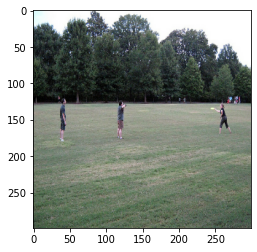

<start> a man in a kitchen with a refrigerator and a refrigerator .


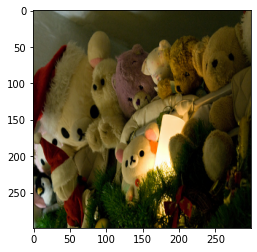

<start> a man is riding a skateboard on a ramp .


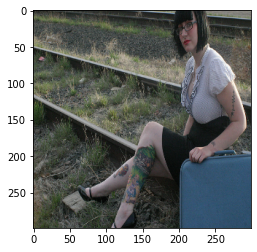

<start> a large white bus is parked in front of a building .


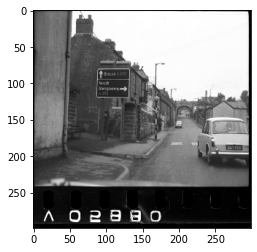

<start> a man is riding a wave on a surfboard .


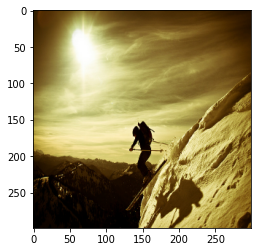

<start> a man in a suit and tie is standing in front of a window .


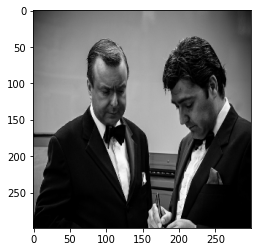

<start> a man is riding a skateboard on a ramp .


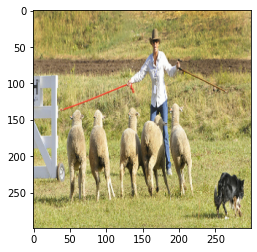

<start> a man in a suit and tie is standing in front of a window .


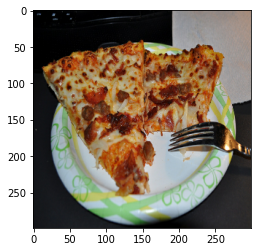

<start> a man in a kitchen with a refrigerator and a refrigerator .


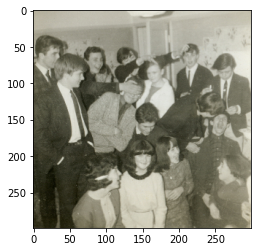

<start> a man in a red shirt is surfing on a wave .


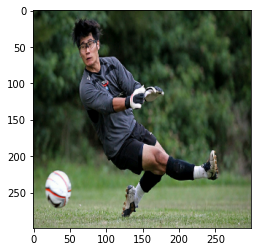

<start> a man is sitting on a bench in a park .


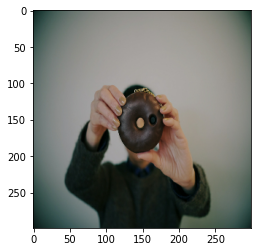

<start> a man in a suit and tie is standing in front of a laptop computer .


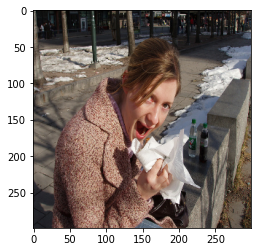

<start> a man in a suit and tie is standing in front of a window .


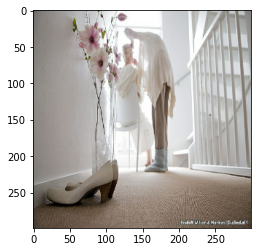

<start> a large white truck parked in front of a building .


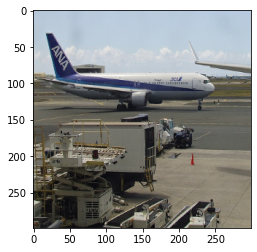

<start> a man in a suit and tie is standing in front of a building .


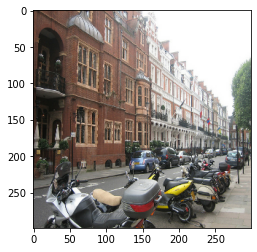

<start> a man in a red shirt is surfing on a wave .


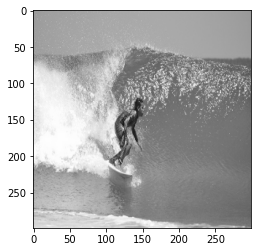

<start> a man in a kitchen with a refrigerator and a refrigerator .


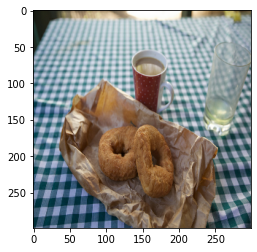

<start> a man in a red shirt is skiing down a hill .


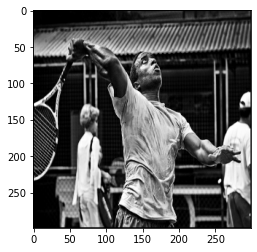

<start> a dog is sitting on a couch with a [UNK] .


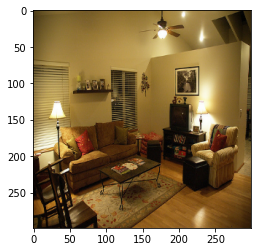

<start> a large white bus is parked in front of a building .


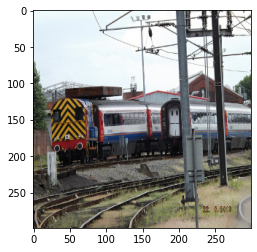

In [115]:
for i in test_data.take(20):
    img=i['image'][0]
    img=tf.expand_dims(img,0)
    tokens=tokenizer.tokenize('<start>')[0:-1]
    tokens=tf.expand_dims(tokens,0).numpy()
    for i in range(68):
        mask=tf.math.not_equal(tokens,0)
        probs=model.calculate_probs(img,tokens,mask)
        prediction=tf.argmax(probs,-1)[0][i].numpy()
        if prediction==tokenizer.tokenize('<end>').numpy()[0]:
            break
        tokens[0,i+1]=prediction
    print(tokenizer.untokenize(tokens[0]))
    plt.imshow(img.numpy().astype(int)[0])
    plt.show()